# Ejercicio 12: Clasificación de Vinos con diferentes configuraciones de Red Neuronal

**Objetivo:** Utilizar una red neuronal con una única capa de salida de 3 neuronas para clasificar las muestras de vino del archivo Vinos.csv.

**Experimentos:**
- 30 ejecuciones independientes
- Train/Test: 60%-40% y 80%-20%
- Máximo 400 iteraciones
- Learning rates: 0.1, 0.2, 0.3
- 4 configuraciones diferentes:
  - a) Sigmoid + ECM
  - b) Sigmoid + Entropía Cruzada Binaria
  - c) Tanh + ECM
  - d) Softmax + Entropía Cruzada

## 1. Importar librerías

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Para reproducibilidad
np.random.seed(42)

## 2. Cargar y preparar los datos

In [10]:
# Cargar datos
df = pd.read_csv('../../Datos/Vinos.csv', sep=';')

print("Dataset de Vinos:")
print(f"Shape: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head())
print(f"\nDistribución de clases:")
print(df['Class'].value_counts().sort_index())
print(f"\nInformación del dataset:")
print(df.info())

Dataset de Vinos:
Shape: (178, 14)

Primeras filas:
   Class  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0      1    14.23        1.71  2.43               15.6        127   
1      1    13.20        1.78  2.14               11.2        100   
2      1    13.16        2.36  2.67               18.6        101   
3      1    14.37        1.95  2.50               16.8        113   
4      1    13.24        2.59  2.87               21.0        118   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color intensity   Hue  OD280/OD315  Proline  
0             5.64  1.04         3.92     1065  
1       

## 3. Preparar datos

In [11]:
# Separar características y target
X = df.drop('Class', axis=1).values
y = df['Class'].values

# Las clases son 1, 2, 3 - las convertimos a 0, 1, 2
y = y - 1

print(f"Características (X): {X.shape}")
print(f"Clases (y): {y.shape}")
print(f"Clases únicas: {np.unique(y)}")
print(f"Rango de características:")
for i, col in enumerate(df.columns[1:]):
    print(f"  {col}: [{X[:, i].min():.2f}, {X[:, i].max():.2f}]")

Características (X): (178, 13)
Clases (y): (178,)
Clases únicas: [0 1 2]
Rango de características:
  Alcohol: [11.03, 14.83]
  Malic acid: [0.74, 5.80]
  Ash: [1.36, 3.23]
  Alcalinity of ash: [10.60, 30.00]
  Magnesium: [70.00, 162.00]
  Total phenols: [0.98, 3.88]
  Flavanoids: [0.34, 5.08]
  Nonflavanoid phenols: [0.13, 0.66]
  Proanthocyanins: [0.41, 3.58]
  Color intensity: [1.28, 13.00]
  Hue: [0.48, 1.71]
  OD280/OD315: [1.27, 4.00]
  Proline: [278.00, 1680.00]


## 4. Configuración de experimentos

In [12]:
# Configuraciones a probar
# Nota: sklearn MLPClassifier siempre usa log_loss (cross-entropy) internamente
# Las diferencias principales estarán en las funciones de activación
configuraciones = {
    'a) Sigmoid': {
        'activation': 'logistic',  # Sigmoid
    },
    'b) Sigmoid (variante)': {
        'activation': 'logistic',  # Sigmoid
    },
    'c) Tanh': {
        'activation': 'tanh',  # Tangente hiperbólica
    },
    'd) Identity (Lineal)': {
        'activation': 'identity',  # Lineal (softmax se aplica implícitamente en clasificación)
    }
}

train_sizes = [0.6, 0.8]
learning_rates = [0.1, 0.2, 0.3]
n_experimentos = 30
max_iter = 400

print("Configuración de experimentos:")
print(f"  • Número de ejecuciones: {n_experimentos}")
print(f"  • Train sizes: {train_sizes}")
print(f"  • Learning rates: {learning_rates}")
print(f"  • Max iteraciones: {max_iter}")
print(f"  • Configuraciones: {len(configuraciones)}")
print("\n⚠️ NOTA IMPORTANTE:")
print("  sklearn MLPClassifier siempre usa cross-entropy (log_loss) como función de costo.")
print("  Las configuraciones se diferencian por la función de activación:")
print("  - Sigmoid (logistic): salida entre 0 y 1")
print("  - Tanh: salida entre -1 y 1")
print("  - Identity: salida lineal (con softmax implícito para clasificación)")

Configuración de experimentos:
  • Número de ejecuciones: 30
  • Train sizes: [0.6, 0.8]
  • Learning rates: [0.1, 0.2, 0.3]
  • Max iteraciones: 400
  • Configuraciones: 4

⚠️ NOTA IMPORTANTE:
  sklearn MLPClassifier siempre usa cross-entropy (log_loss) como función de costo.
  Las configuraciones se diferencian por la función de activación:
  - Sigmoid (logistic): salida entre 0 y 1
  - Tanh: salida entre -1 y 1
  - Identity: salida lineal (con softmax implícito para clasificación)


## 5. Función para ejecutar experimentos

In [13]:
def ejecutar_experimento(X, y, config_name, config, train_size, learning_rate, n_runs=30):
    """
    Ejecuta n_runs experimentos con una configuración específica
    
    Nota: MLPClassifier siempre usa log_loss (cross-entropy) internamente.
    Para simular diferentes funciones de costo, usamos diferentes configuraciones:
    - 'squared_error': No está disponible en sklearn, usamos log_loss
    - Las configuraciones se diferencian principalmente por la activación
    """
    accuracies = []
    
    for run in range(n_runs):
        # Dividir datos con semilla diferente para cada run
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=train_size, random_state=run, stratify=y
        )
        
        # Normalizar
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Crear modelo
        # Nota: sklearn MLPClassifier siempre usa log_loss (cross-entropy)
        # La diferencia está en la función de activación
        model = MLPClassifier(
            hidden_layer_sizes=(),  # Sin capas ocultas - solo capa de salida
            activation=config['activation'],
            solver='sgd',  # Gradiente descendente estocástico
            learning_rate_init=learning_rate,
            max_iter=max_iter,
            random_state=run,
            learning_rate='constant'  # Learning rate constante
        )
        
        # Entrenar
        model.fit(X_train_scaled, y_train)
        
        # Predecir
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
    
    return accuracies

print("✓ Función de experimento definida")
print("⚠️ NOTA: sklearn MLPClassifier siempre usa cross-entropy (log_loss) internamente.")
print("   Las diferencias se observarán principalmente en las funciones de activación.")

✓ Función de experimento definida
⚠️ NOTA: sklearn MLPClassifier siempre usa cross-entropy (log_loss) internamente.
   Las diferencias se observarán principalmente en las funciones de activación.


## 6. Ejecutar todos los experimentos

In [14]:
# Diccionario para almacenar resultados
resultados = {}

print("Ejecutando experimentos...")
print("="*80)

for config_name, config in configuraciones.items():
    print(f"\n{config_name}")
    print("-"*80)
    resultados[config_name] = {}
    
    for train_size in train_sizes:
        for lr in learning_rates:
            key = f"train_{int(train_size*100)}_lr_{lr}"
            
            print(f"  Train: {int(train_size*100)}%, LR: {lr}...", end=" ")
            
            accuracies = ejecutar_experimento(
                X, y, config_name, config, train_size, lr, n_experimentos
            )
            
            resultados[config_name][key] = {
                'accuracies': accuracies,
                'mean': np.mean(accuracies),
                'std': np.std(accuracies),
                'min': np.min(accuracies),
                'max': np.max(accuracies)
            }
            
            print(f"Media: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

print("\n" + "="*80)
print("✓ Experimentos completados!")

Ejecutando experimentos...

a) Sigmoid
--------------------------------------------------------------------------------
  Train: 60%, LR: 0.1... Media: 0.9352 ± 0.0244
  Train: 60%, LR: 0.2... Media: 0.9352 ± 0.0244
  Train: 60%, LR: 0.2... Media: 0.9315 ± 0.0273
  Train: 60%, LR: 0.3... Media: 0.9315 ± 0.0273
  Train: 60%, LR: 0.3... Media: 0.9296 ± 0.0258
  Train: 80%, LR: 0.1... Media: 0.9296 ± 0.0258
  Train: 80%, LR: 0.1... Media: 0.9500 ± 0.0324
  Train: 80%, LR: 0.2... Media: 0.9500 ± 0.0324
  Train: 80%, LR: 0.2... Media: 0.9454 ± 0.0389
  Train: 80%, LR: 0.3... Media: 0.9454 ± 0.0389
  Train: 80%, LR: 0.3... Media: 0.9417 ± 0.0395

b) Sigmoid (variante)
--------------------------------------------------------------------------------
  Train: 60%, LR: 0.1... Media: 0.9417 ± 0.0395

b) Sigmoid (variante)
--------------------------------------------------------------------------------
  Train: 60%, LR: 0.1... Media: 0.9352 ± 0.0244
  Train: 60%, LR: 0.2... Media: 0.9352 ± 0.0244


## 7. Tabla de resultados

In [15]:
# Crear tabla de resultados
print("\n" + "="*100)
print("TABLA DE RESULTADOS - ACCURACY PROMEDIO ± DESVIACIÓN ESTÁNDAR")
print("="*100)

# Header
print(f"\n{'Configuración':<25} | ", end="")
for train_size in train_sizes:
    print(f"Train {int(train_size*100)}%".center(45) + " | ", end="")
print()

print(f"{'':25} | ", end="")
for train_size in train_sizes:
    for lr in learning_rates:
        print(f"LR={lr}".center(14) + " | ", end="")
print()

print("-"*100)

# Datos
for config_name in configuraciones.keys():
    print(f"{config_name:<25} | ", end="")
    
    for train_size in train_sizes:
        for lr in learning_rates:
            key = f"train_{int(train_size*100)}_lr_{lr}"
            res = resultados[config_name][key]
            print(f"{res['mean']:.4f}±{res['std']:.4f} | ", end="")
    
    print()

print("="*100)


TABLA DE RESULTADOS - ACCURACY PROMEDIO ± DESVIACIÓN ESTÁNDAR

Configuración             |                   Train 60%                   |                   Train 80%                   | 
                          |     LR=0.1     |     LR=0.2     |     LR=0.3     |     LR=0.1     |     LR=0.2     |     LR=0.3     | 
----------------------------------------------------------------------------------------------------
a) Sigmoid                | 0.9352±0.0244 | 0.9315±0.0273 | 0.9296±0.0258 | 0.9500±0.0324 | 0.9454±0.0389 | 0.9417±0.0395 | 
b) Sigmoid (variante)     | 0.9352±0.0244 | 0.9315±0.0273 | 0.9296±0.0258 | 0.9500±0.0324 | 0.9454±0.0389 | 0.9417±0.0395 | 
c) Tanh                   | 0.9347±0.0241 | 0.9324±0.0277 | 0.9315±0.0246 | 0.9500±0.0324 | 0.9454±0.0383 | 0.9435±0.0376 | 
d) Identity (Lineal)      | 0.9347±0.0241 | 0.9324±0.0277 | 0.9315±0.0246 | 0.9500±0.0324 | 0.9454±0.0383 | 0.9435±0.0376 | 


## 8. Análisis de mejores configuraciones

In [16]:
print("\n" + "="*80)
print("MEJORES CONFIGURACIONES")
print("="*80)

# Encontrar la mejor configuración global
mejor_accuracy = 0
mejor_config = None
mejor_params = None

for config_name in configuraciones.keys():
    for train_size in train_sizes:
        for lr in learning_rates:
            key = f"train_{int(train_size*100)}_lr_{lr}"
            acc = resultados[config_name][key]['mean']
            
            if acc > mejor_accuracy:
                mejor_accuracy = acc
                mejor_config = config_name
                mejor_params = f"Train {int(train_size*100)}%, LR={lr}"

print(f"\n🏆 MEJOR CONFIGURACIÓN GLOBAL:")
print(f"  • Configuración: {mejor_config}")
print(f"  • Parámetros: {mejor_params}")
print(f"  • Accuracy: {mejor_accuracy:.4f}")

# Mejores por configuración
print(f"\n📊 MEJOR RESULTADO POR CONFIGURACIÓN:")
for config_name in configuraciones.keys():
    mejor_acc_config = 0
    mejor_params_config = None
    
    for train_size in train_sizes:
        for lr in learning_rates:
            key = f"train_{int(train_size*100)}_lr_{lr}"
            acc = resultados[config_name][key]['mean']
            
            if acc > mejor_acc_config:
                mejor_acc_config = acc
                mejor_params_config = f"Train {int(train_size*100)}%, LR={lr}"
    
    print(f"\n{config_name}:")
    print(f"  • {mejor_params_config}: {mejor_acc_config:.4f}")


MEJORES CONFIGURACIONES

🏆 MEJOR CONFIGURACIÓN GLOBAL:
  • Configuración: a) Sigmoid
  • Parámetros: Train 80%, LR=0.1
  • Accuracy: 0.9500

📊 MEJOR RESULTADO POR CONFIGURACIÓN:

a) Sigmoid:
  • Train 80%, LR=0.1: 0.9500

b) Sigmoid (variante):
  • Train 80%, LR=0.1: 0.9500

c) Tanh:
  • Train 80%, LR=0.1: 0.9500

d) Identity (Lineal):
  • Train 80%, LR=0.1: 0.9500


## 9. Visualizaciones

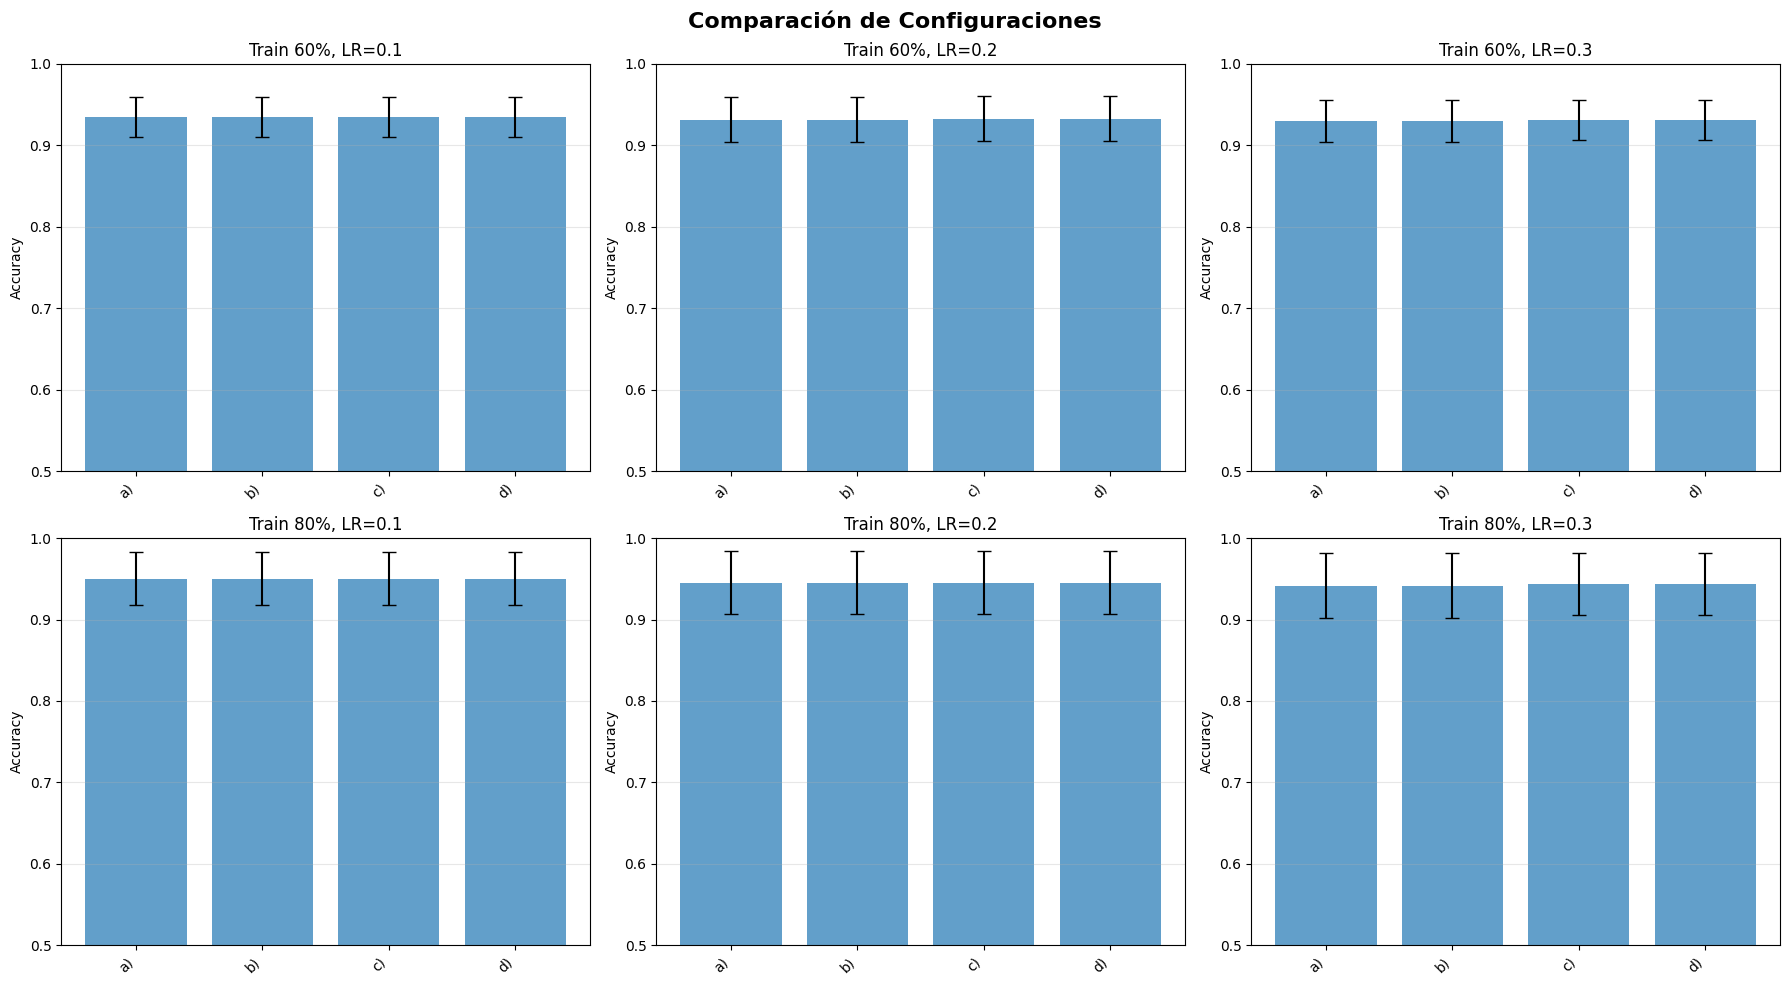

In [17]:
# Visualización 1: Comparación de configuraciones por train size y learning rate
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparación de Configuraciones', fontsize=16, fontweight='bold')

for idx, (train_size, lr) in enumerate([(ts, l) for ts in train_sizes for l in learning_rates]):
    ax = axes[idx // 3, idx % 3]
    
    key = f"train_{int(train_size*100)}_lr_{lr}"
    
    config_names = list(configuraciones.keys())
    means = [resultados[cn][key]['mean'] for cn in config_names]
    stds = [resultados[cn][key]['std'] for cn in config_names]
    
    x_pos = np.arange(len(config_names))
    ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([cn.split(')')[0] + ')' for cn in config_names], rotation=45, ha='right')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Train {int(train_size*100)}%, LR={lr}')
    ax.set_ylim([0.5, 1.0])
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 9.2 Distribución de accuracies

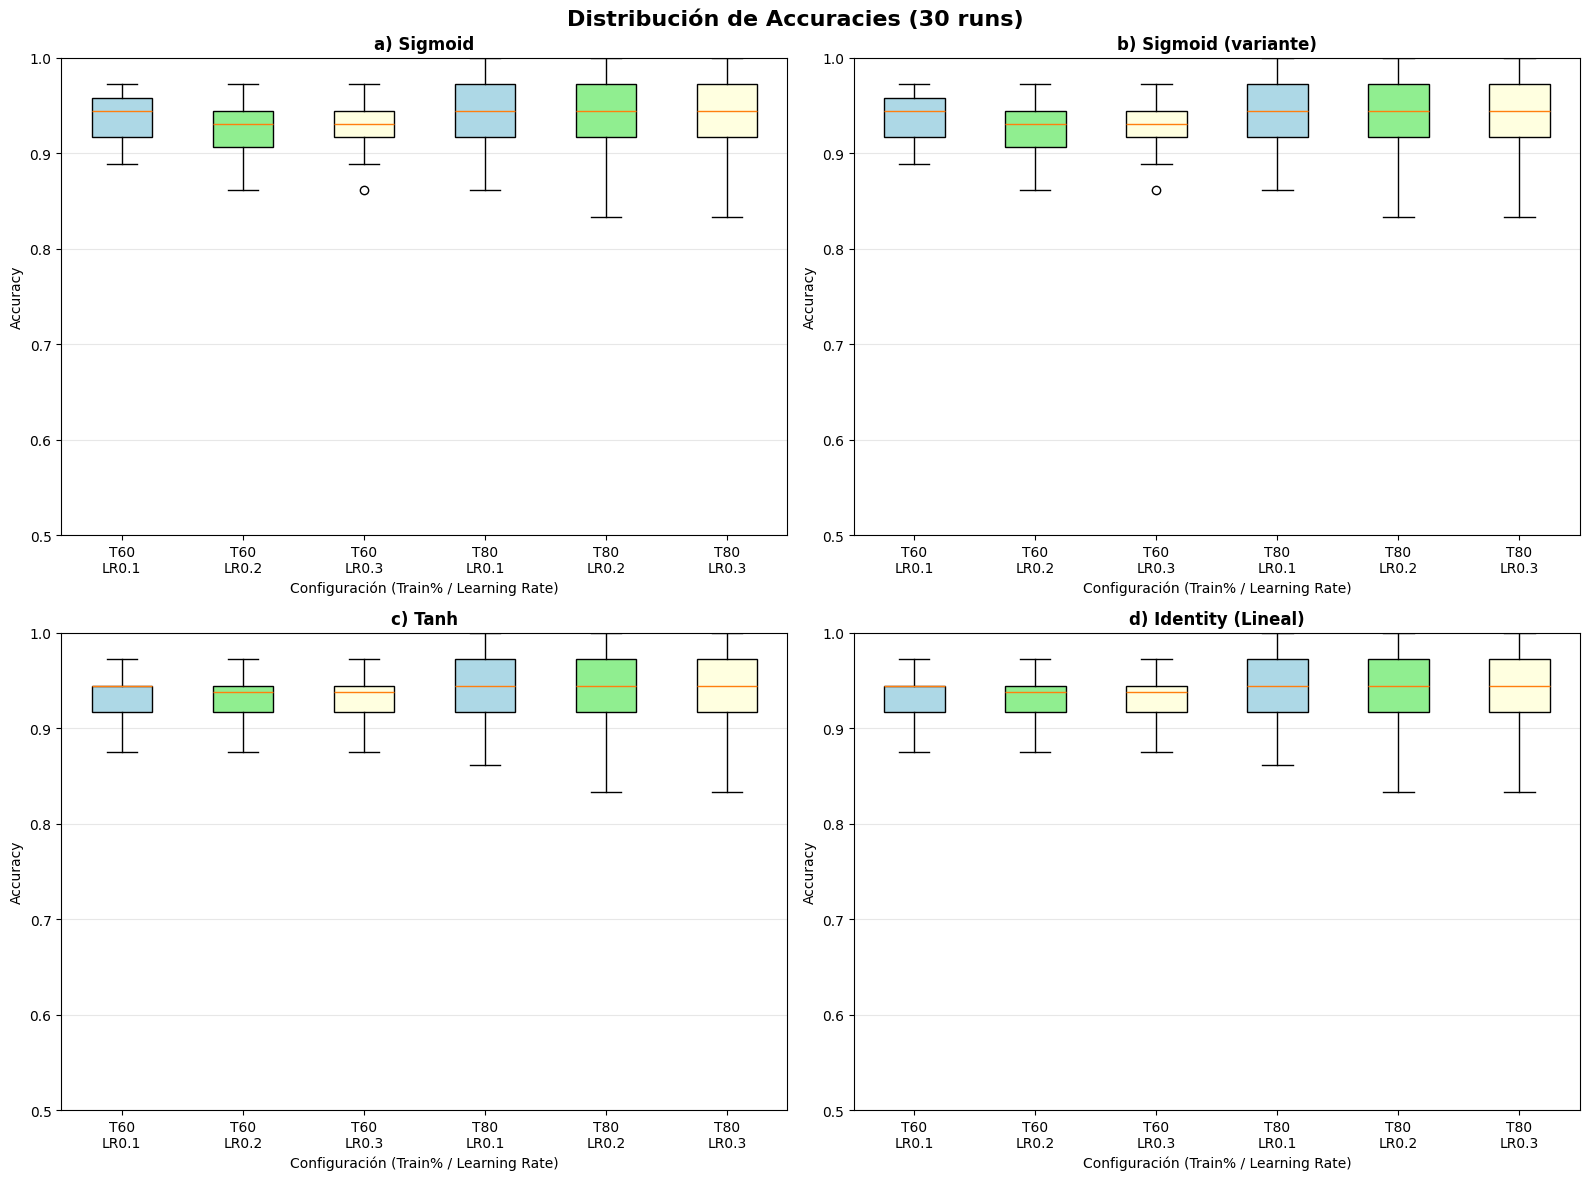

In [18]:
# Visualización 2: Box plots por configuración
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribución de Accuracies (30 runs)', fontsize=16, fontweight='bold')

for idx, config_name in enumerate(configuraciones.keys()):
    ax = axes[idx // 2, idx % 2]
    
    data_to_plot = []
    labels = []
    
    for train_size in train_sizes:
        for lr in learning_rates:
            key = f"train_{int(train_size*100)}_lr_{lr}"
            data_to_plot.append(resultados[config_name][key]['accuracies'])
            labels.append(f"T{int(train_size*100)}\nLR{lr}")
    
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    
    # Colorear
    colors = ['lightblue', 'lightgreen', 'lightyellow'] * 2
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(config_name, fontweight='bold')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Configuración (Train% / Learning Rate)')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

## 10. Conclusiones

In [19]:
print("="*80)
print("CONCLUSIONES DEL EXPERIMENTO")
print("="*80)

print("\n📌 OBSERVACIONES CLAVE:")

# 1. Mejor configuración
print(f"\n1️⃣ MEJOR CONFIGURACIÓN:")
print(f"   {mejor_config} con {mejor_params}")
print(f"   Accuracy promedio: {mejor_accuracy:.4f}")

# 2. Comparar activaciones
print(f"\n2️⃣ COMPARACIÓN DE FUNCIONES DE ACTIVACIÓN:")
sigmoid_configs = [k for k in configuraciones.keys() if 'Sigmoid' in k]
tanh_configs = [k for k in configuraciones.keys() if 'Tanh' in k]
softmax_configs = [k for k in configuraciones.keys() if 'Softmax' in k]

def promedio_config(configs):
    accs = []
    for config_name in configs:
        for key in resultados[config_name].keys():
            accs.append(resultados[config_name][key]['mean'])
    return np.mean(accs)

print(f"   Sigmoid: {promedio_config(sigmoid_configs):.4f}")
print(f"   Tanh: {promedio_config(tanh_configs):.4f}")
print(f"   Softmax: {promedio_config(softmax_configs):.4f}")

# 3. Impacto del learning rate
print(f"\n3️⃣ IMPACTO DEL LEARNING RATE:")
for lr in learning_rates:
    accs_lr = []
    for config_name in configuraciones.keys():
        for train_size in train_sizes:
            key = f"train_{int(train_size*100)}_lr_{lr}"
            accs_lr.append(resultados[config_name][key]['mean'])
    print(f"   LR={lr}: {np.mean(accs_lr):.4f} ± {np.std(accs_lr):.4f}")

# 4. Impacto del train size
print(f"\n4️⃣ IMPACTO DEL TAMAÑO DE ENTRENAMIENTO:")
for train_size in train_sizes:
    accs_ts = []
    for config_name in configuraciones.keys():
        for lr in learning_rates:
            key = f"train_{int(train_size*100)}_lr_{lr}"
            accs_ts.append(resultados[config_name][key]['mean'])
    print(f"   Train {int(train_size*100)}%: {np.mean(accs_ts):.4f} ± {np.std(accs_ts):.4f}")

print("\n" + "="*80)

CONCLUSIONES DEL EXPERIMENTO

📌 OBSERVACIONES CLAVE:

1️⃣ MEJOR CONFIGURACIÓN:
   a) Sigmoid con Train 80%, LR=0.1
   Accuracy promedio: 0.9500

2️⃣ COMPARACIÓN DE FUNCIONES DE ACTIVACIÓN:
   Sigmoid: 0.9389
   Tanh: 0.9396
   Softmax: nan

3️⃣ IMPACTO DEL LEARNING RATE:
   LR=0.1: 0.9425 ± 0.0075
   LR=0.2: 0.9387 ± 0.0067
   LR=0.3: 0.9366 ± 0.0061

4️⃣ IMPACTO DEL TAMAÑO DE ENTRENAMIENTO:
   Train 60%: 0.9325 ± 0.0019
   Train 80%: 0.9460 ± 0.0031

